# ARMAX models

This tutorial demonstrates ARX and ARMAX models described in [the previous page](timeseries_intro).

We want to see if the preditions of an ordinary linear regression model are improved by expanding it with an AR(p) model. This is what we call the ARX(p) formulation:

```{math}
:label: armax_01
y_t = \sum_{i=1}^p \varphi_i y_{t-i} + \sum_{k=0}^r \beta_k x_{t-k} + \varepsilon_t
```

[Autoregressive models](timeseries_intro.md) (AR) are based on the idea that the current value of the series, $y_t$, can be explained as a function of $p$ past values, $y_{t−1}$, $y_{t−2}$, ..., $y_{t−p}$. They are essentially linear regression models which take *lagged* copies of the dependent variable as explanatory variables. Other variables can be added, leading to the so-called ARX model (AR model with eXplanatory variables).

This example has one explanatory variable $x$ which lagged values may also be used up to a certain lag $r$. Further expanding this model with a MA(q) term yields the ARMAX(p,q) fomulation:

```{math}
:label: armax_02
y_t = \sum_{i=1}^p \varphi_i y_{t-i} + \sum_{j=1}^q \theta_j \varepsilon_{t-j} + \sum_{k=0}^r \beta_k x_{t-k} + \varepsilon_t
```

The target of this exercise is to find whether the ARMAX expansion improves the prediction metrics of an ordinary linear model. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import arviz as az
from cmdstanpy import CmdStanModel

## Data

The data comprises the heating power, indoor and outdoor air temperatures of a single-family house, with a 2 hour time step between measurements. The data file can be downloaded [here](https://github.com/srouchier/buildingenergygeeks/blob/master/data/armaxdata.csv).

In [2]:
df = pd.read_csv('data/armaxdata.csv')
df.head()

,datetime,Ti,Te,P
0,2023-04-07 20:00:00,21.017708,8.008333,1127.547691
1,2023-04-07 22:00:00,21.022083,6.254167,1095.384059
2,2023-04-08 00:00:00,21.023750,5.258333,1073.813890
3,2023-04-08 02:00:00,21.010625,3.381250,1101.343786
4,2023-04-08 04:00:00,21.009167,3.118750,1131.881637


Text(0.5, 0, 'Ti-Te (C)')

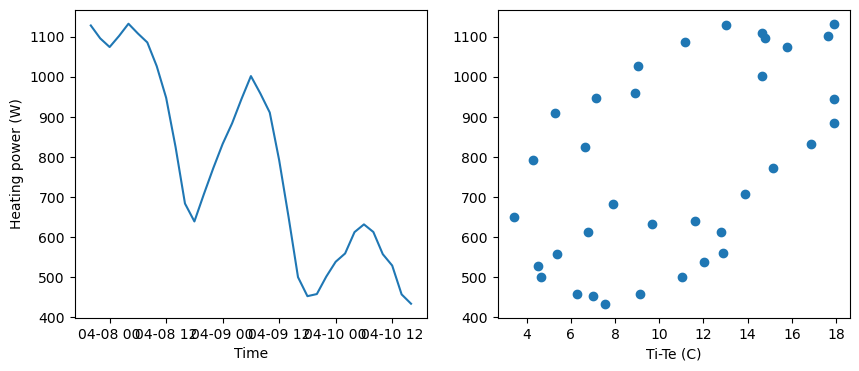

In [3]:
# A plot of the dependent variable vs. each of the explanatory variables
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(pd.to_datetime(df['datetime']), df['P'])
axes[1].scatter(df['Ti']-df['Te'], df['P'])
axes[0].set_ylabel("Heating power (W)")
axes[0].set_xlabel("Time")
axes[1].set_xlabel("Ti-Te (C)")

We may expect a linear relationship between the heating power $y$ and the indoor-outdoor temperature difference $x=T_i-T_e$. However, because of the building's thermal inertia exceeding the time step size, it is likely that each current value $y_t$ depends on previous instances $y_{t-1}$ and $x_{t-1}$.

Let us use about two thirds of the dataset for model training, and the last third to watch the energy use forecasted by fitted models:

In [4]:
N = len(df)
N_train = round(2/3*N)
X = df['Ti']-df['Te']
y = df.loc[:N_train-1,'P']


## Linear regression

We have Stan models of an ordinary linear regression model, and of ARX and ARMAX model of any orders (p,q,r). All model files can be downloaded from [this folder](https://github.com/srouchier/buildingenergygeeks/tree/master/models).

In [5]:
linreg = CmdStanModel(stan_file='models/linearregression.stan')
arx = CmdStanModel(stan_file='models/arx.stan')
armax = CmdStanModel(stan_file='models/armax.stan')

Let us start by fitting an ordinary linear regression model which we will use later for model comparison reference:

In [6]:
# Data declaration for the linear regression model
linreg_data = {
    "N": N_train,
    "K": 1,
    "x": X.values[:N_train, np.newaxis],
    "y": y.values,
}

# Fitting the LR model
fit_linreg = linreg.sample(data=linreg_data, show_progress=False)

06:20:45 - cmdstanpy - INFO - CmdStan start processing
06:20:45 - cmdstanpy - INFO - Chain [1] start processing
06:20:45 - cmdstanpy - INFO - Chain [2] start processing
06:20:45 - cmdstanpy - INFO - Chain [3] start processing
06:20:45 - cmdstanpy - INFO - Chain [4] start processing


06:20:46 - cmdstanpy - INFO - Chain [1] done processing
06:20:46 - cmdstanpy - INFO - Chain [4] done processing
06:20:46 - cmdstanpy - INFO - Chain [2] done processing
06:20:46 - cmdstanpy - INFO - Chain [3] done processing


Now, the choice of ARMAX orders (p,q,r) is not trivial. There is no universal rule telling us how many previous time steps will make the energy forecasts more robust. The general recommendation is to fit several models of increasing complexity, until out model comparison metrics tell us to stop. Let us fit a few models, which is fast once the initial model has been compiled.

In [7]:
arx1_data = {
    "N_train": N_train,
    "N": N,
    "K": 1,
    "P": 1,
    "R": 1,
    "x": X.values[:, np.newaxis] ,
    "y": y.values,
}

fit_arx1 = arx.sample(data=arx1_data, show_progress=False)

arx2_data = {
    "N_train": N_train,
    "N": N,
    "K": 1,
    "P": 2,
    "R": 1,
    "x": X.values[:, np.newaxis] ,
    "y": y.values,
}

fit_arx2 = arx.sample(data=arx2_data, show_progress=False)

arx3_data = {
    "N_train": N_train,
    "N": N,
    "K": 1,
    "P": 2,
    "R": 2,
    "x": X.values[:, np.newaxis] ,
    "y": y.values,
}

fit_arx3 = arx.sample(data=arx3_data, show_progress=False)

06:20:47 - cmdstanpy - INFO - CmdStan start processing
06:20:47 - cmdstanpy - INFO - Chain [1] start processing
06:20:47 - cmdstanpy - INFO - Chain [2] start processing
06:20:47 - cmdstanpy - INFO - Chain [3] start processing
06:20:47 - cmdstanpy - INFO - Chain [4] start processing
06:20:55 - cmdstanpy - INFO - Chain [2] done processing
06:20:57 - cmdstanpy - INFO - Chain [4] done processing
06:20:57 - cmdstanpy - INFO - Chain [1] done processing
06:20:57 - cmdstanpy - INFO - Chain [3] done processing
06:20:58 - cmdstanpy - INFO - CmdStan start processing
06:20:58 - cmdstanpy - INFO - Chain [1] start processing
06:20:58 - cmdstanpy - INFO - Chain [2] start processing
06:20:58 - cmdstanpy - INFO - Chain [3] start processing
06:20:58 - cmdstanpy - INFO - Chain [4] start processing
06:21:22 - cmdstanpy - INFO - Chain [1] done processing
06:21:24 - cmdstanpy - INFO - Chain [2] done processing
06:21:25 - cmdstanpy - INFO - Chain [3] done processing
06:21:28 - cmdstanpy - INFO - Chain [4] do

Let us add an ARMAX model to the pool:

In [8]:
armax_data = {
    "N_train": N_train,
    "N": N,
    "K": 1,
    "P": 1,
    "Q": 1,
    "R": 1,
    "x": X.values[:, np.newaxis] ,
    "y": y.values,
}

fit_armax = armax.sample(data=armax_data, show_progress=False)

06:21:59 - cmdstanpy - INFO - CmdStan start processing
06:21:59 - cmdstanpy - INFO - Chain [1] start processing
06:21:59 - cmdstanpy - INFO - Chain [2] start processing
06:21:59 - cmdstanpy - INFO - Chain [3] start processing
06:21:59 - cmdstanpy - INFO - Chain [4] start processing


06:22:10 - cmdstanpy - INFO - Chain [4] done processing
06:22:11 - cmdstanpy - INFO - Chain [2] done processing
06:22:13 - cmdstanpy - INFO - Chain [1] done processing
06:22:13 - cmdstanpy - INFO - Chain [3] done processing
06:22:13 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 40 divergent transitions (4.0%)
	Chain 2 had 20 divergent transitions (2.0%)
	Chain 3 had 29 divergent transitions (2.9%)
	Chain 4 had 37 divergent transitions (3.7%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


We now compare all these models in order to only select one for posterior analysis.

In [9]:
idata_linreg = az.from_cmdstanpy(
    posterior = fit_linreg,
    posterior_predictive="y_hat",
    log_likelihood="log_lik",
)
idata_arx1 = az.from_cmdstanpy(
    posterior = fit_arx1,
    posterior_predictive="y_hat",
    log_likelihood="log_lik",
)
idata_arx2 = az.from_cmdstanpy(
    posterior = fit_arx2,
    posterior_predictive="y_hat",
    log_likelihood="log_lik",
)
idata_arx3 = az.from_cmdstanpy(
    posterior = fit_arx3,
    posterior_predictive="y_hat",
    log_likelihood="log_lik",
)
idata_armax = az.from_cmdstanpy(
    posterior = fit_armax,
    posterior_predictive="y_hat",
    log_likelihood="log_lik",
)

df_comp_loo = az.compare({"linreg": idata_linreg, "arx1": idata_arx1, "arx2": idata_arx2, "arx3": idata_arx3, "arxmax": idata_armax}, ic="loo")
df_comp_loo

arviz - WARNING - Array contains NaN-value.
/home/simon/anaconda3/envs/poem/lib/python3.13/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/simon/anaconda3/envs/poem/lib/python3.13/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
arx2,0,-103.396246,4.856709,0.000000,1.000000e+00,7.235023,0.000000,True,log
arx3,1,-104.615270,6.405578,1.219024,3.599302e-12,7.672517,1.520233,True,log
arx1,2,-107.561120,4.663292,4.164874,2.050683e-12,5.673898,4.558640,True,log
arxmax,3,-108.130806,5.292030,4.734560,5.088846e-13,5.821429,4.730052,True,log
linreg,4,-151.296510,2.012209,47.900264,0.000000e+00,1.916102,7.322429,False,log


It looks like the best model according to the LOO criterion is the second ARX model we defined, using $p=2$ and $r=1$. The other ARX and ARMAX models come close, but all are a significany improvement from the linear regression in terms of elpd.

## Posterior analysis

In [10]:
fs = fit_arx2.summary(percentiles=(5, 50, 95))
fs.loc[['alpha', 'phi[1]', 'phi[2]', 'beta[1,1]', 'beta[1,2]', 'sigma']]

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
alpha,-38.785400,1.155390,50.603400,48.393000,-121.478000,-38.993800,47.127700,1923.76,1776.38,1.00199
phi[1],1.060290,0.008094,0.273956,0.259596,0.621424,1.055360,1.522520,1168.82,1226.96,1.00239
phi[2],-0.214849,0.006826,0.235300,0.224055,-0.612585,-0.209717,0.158765,1213.09,1318.39,1.00252
"beta[1,1]",5.004210,0.120778,4.197610,4.010650,-1.900230,4.966280,11.955700,1270.83,1554.13,1.00208
"beta[1,2]",8.193960,0.205776,6.866260,6.412250,-3.228970,8.318390,19.202300,1142.12,1384.58,1.00306
sigma,30.057400,0.148224,5.751920,5.271160,22.308100,29.101100,40.549800,1559.94,1990.28,1.00150


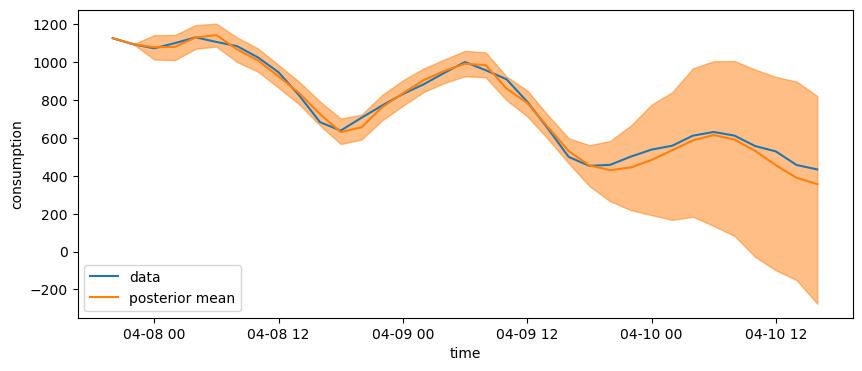

In [11]:
y_hat = idata_arx2.posterior_predictive["y_hat"]

fig, axes = plt.subplots(figsize=(10, 4))
axes.plot(pd.to_datetime(df['datetime']), df['P'], label='data')
axes.plot(pd.to_datetime(df['datetime']), y_hat.mean(("chain", "draw")), c="C1", label="posterior mean")
az.plot_hdi(pd.to_datetime(df['datetime']), y_hat, smooth=False)
axes.set_ylabel("consumption")
axes.set_xlabel("time")
axes.legend()


We can see the posterior high density intervals increase drastically after the end of the training period.